In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import seaborn as sns

# Adress-Merkmal Datensatz erstellen

#### Funktionen

In [3]:
def getDataFromBigQuery(tableName='masterarbeit-245718.ethereum_us.top40k_week1777_features'):
    %env GOOGLE_APPLICATION_CREDENTIALS=./bigquery-service-account.json 
    client = bigquery.Client()
    query = "SELECT * from `" + tableName+"`"; print(query);
    query_job = client.query(query);
    start = time.time();
    data = query_job.result().to_dataframe();  
    featureNames = ['weiReceived', 'weiSent', 'numberOfTranscationsReceived', 'numberOfTranscationsSent', 'avgTimeDiffBetweenSentTransactions', 'avgTimeDiffBetweenReceivedTransactions']
    featureValues = data.loc[:,featureNames]
    done = time.time();
    elapsed = round(done - start);
    return featureValues, elapsed;

0         162513189422179119069
1           8620407981554943587
2           1046945356332478210
3           2408540945984836992
4          16900000000000000000
                  ...          
171150       351346448675664200
171151      6417461194383515259
171152    197638598325100000000
171153       579671218982082105
171154      1071898447536538207
Name: weiReceived, Length: 171155, dtype: object

In [26]:
def getMemoryUsageInMB(data):
    m = data.memory_usage();
    totalBytes = 0;

    for bytes_ in m:
        totalBytes = totalBytes + bytes_;
    
    totalMegabytes = totalBytes/10**6;
    
    return round(totalMegabytes);

In [4]:
def getSampleDigitsDataSet():
    from sklearn import datasets;
    result = datasets.load_digits();
    data = result.data;
    data_df = pd.DataFrame(data)
    data_df = data_df.drop(columns=0)
    labels = pd.DataFrame(result.target.astype(int), columns=["Label"]);
    return data_df, labels;

In [5]:
def getSampleIrisDataSet():
    from sklearn import datasets;
    result = datasets.load_iris();
    data = result.data;
    data_df = pd.DataFrame(data)
    data_df = data_df.drop(columns=0)
    labels = pd.DataFrame(result.target.astype(int), columns=["Label"]);
    return data_df, labels;

In [6]:
def getVerySimpleSampleDataSet():
    x1 = np.array([3, 1, 1, 2, 1, 6, 6, 6, 5, 6, 7, 8, 9, 8, 9, 9, 8]);
    x2 = np.array([5, 4, 5, 6, 5, 8, 6, 7, 6, 7, 1, 2, 1, 2, 3, 2, 3]);
    return pd.DataFrame(np.transpose(np.array([x1, x2])));

#### Test-Daten: Very Simple

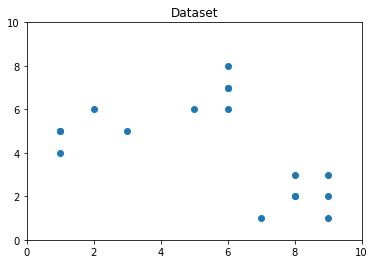

In [7]:
verySimple_featureValues = getVerySimpleSampleDataSet();
plt.plot()
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.title('Dataset')
plt.scatter(verySimple_featureValues.iloc[:,0], verySimple_featureValues.iloc[:,1])
plt.show()

#### Test-Daten: iris

In [8]:
sampleIrisFeatureValues, labels = getSampleIrisDataSet();
sampleIrisFeatureValues

,1,2,3
0,3.5,1.4,0.2
1,3.0,1.4,0.2
2,3.2,1.3,0.2
3,3.1,1.5,0.2
4,3.6,1.4,0.2
...,...,...,...
145,3.0,5.2,2.3
146,2.5,5.0,1.9
147,3.0,5.2,2.0
148,3.4,5.4,2.3


#### Test-Daten: digits

In [97]:
sampleFeatureValues, labels = getSampleDigitsDataSet();
sampleFeatureValues

,1,2,3,4,5,6,7,8,9,10,...,54,55,56,57,58,59,60,61,62,63
0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,16.0,...,4.0,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0
1793,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,16.0,...,1.0,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0
1794,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,13.0,...,0.0,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0
1795,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,14.0,...,2.0,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0


#### Daten

In [5]:
featureValues, elapsed = getDataFromBigQuery('masterarbeit-245718.ethereum_us.top40k_week1777_features');

env: GOOGLE_APPLICATION_CREDENTIALS=./bigquery-service-account.json
SELECT * from `masterarbeit-245718.ethereum_us.top40k_week1777_features`


In [30]:
print("Time to retrieve data from BigQuery: {} Seconds.".format(elapsed))
print("Size of the account feature dataset: {} Megabytes.".format(getMemoryUsageInMB(featureValues)))
featureValues

Time to retrieve data from BigQuery: 14 Seconds.
Size of the account feature dataset: 8 Megabytes.


,weiReceived,weiSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions
0,162513189422179119069,149883649456370636058,647,440,1374.355353,933.965944
1,8620407981554943587,46933986949956081,1012,409,1474.078431,595.009891
2,1046945356332478210,1046945350000000000,14,7,86590.500000,39986.153846
3,2408540945984836992,2408540940000000000,12,6,95865.600000,43602.545455
4,16900000000000000000,10415000000000000000,177,30,18260.517241,3008.835227
...,...,...,...,...,...,...
171150,351346448675664200,351346448675664200,7,7,79644.333333,79644.333333
171151,6417461194383515259,6419707485633515259,7,9,64856.875000,86522.166667
171152,197638598325100000000,198812506917000000000,7,7,86389.666667,86395.500000
171153,579671218982082105,572321220000000000,7,7,86226.166667,86503.666667


# Merkmalsausprägungen standardisieren, so dass Mittelwert und Standardabweichung für alle Merkmale gleich sind 

#### Funktionen

In [13]:
def standardize(featureValues):
    scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
    featureValues_std= scaler.fit_transform(featureValues);
    featureValues_std = pd.DataFrame(featureValues_std, columns=featureValues.columns);
    return featureValues_std;

In [15]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
scaler.fit(featureValues)
scaler.transform(featureValues)


array([[ 4.35267167e-02,  3.99313478e-02,  1.71823395e+00,
         9.12050872e-01, -4.25451196e-01, -4.47102320e-01],
       [-1.93907553e-02, -2.39080313e-02,  2.69902300e+00,
         8.46343862e-01, -4.24331542e-01, -4.50921677e-01],
       [-2.24870871e-02, -2.34819668e-02,  1.73038886e-02,
        -5.72769221e-03,  5.31324444e-01, -7.06230652e-03],
       ...,
       [ 5.78873768e-02,  6.07779599e-02, -1.50576447e-03,
        -5.72769221e-03,  5.29069561e-01,  5.15878159e-01],
       [-2.26781273e-02, -2.36841850e-02, -1.50576447e-03,
        -5.72769221e-03,  5.27233843e-01,  5.17096981e-01],
       [-2.24768853e-02, -2.29833670e-02, -1.50576447e-03,
        -1.63255971e-02,  2.49976999e+00,  5.15883793e-01]])

#### Test-Verfahren: Very Simple Dataset

In [14]:
verySimple_featureValues_std = standardize(verySimple_featureValues);
verySimple_featureValues_std

,0,1
0,-0.908037,0.326357
1,-1.609702,-0.135982
2,-1.609702,0.326357
3,-1.258870,0.788696
4,-1.609702,0.326357
5,0.144460,1.713374
6,0.144460,0.788696
7,0.144460,1.251035
8,-0.206372,0.788696
9,0.144460,1.251035


#### Test-Verfahren: Iris

In [15]:
sampleIrisFeatureValues_std = standardize(sampleIrisFeatureValues);
sampleIrisFeatureValues_std

,1,2,3
0,1.019004,-1.340227,-1.315444
1,-0.131979,-1.340227,-1.315444
2,0.328414,-1.397064,-1.315444
3,0.098217,-1.283389,-1.315444
4,1.249201,-1.340227,-1.315444
...,...,...,...
145,-0.131979,0.819596,1.448832
146,-1.282963,0.705921,0.922303
147,-0.131979,0.819596,1.053935
148,0.788808,0.933271,1.448832


#### Test-Verfahren: Digits

In [16]:
sampleFeatureValues_std = standardize(sampleFeatureValues);
sampleFeatureValues_std

,1,2,3,4,5,6,7,8,9,10,...,54,55,56,57,58,59,60,61,62,63
0,-0.335016,-0.043081,0.274072,-0.664478,-0.844129,-0.409724,-0.125023,-0.059078,-0.624009,0.482974,...,-0.757436,-0.209785,-0.023596,-0.299081,0.086719,0.208293,-0.366771,-1.146647,-0.505670,-0.196008
1,-0.335016,-1.094937,0.038648,0.268751,-0.138020,-0.409724,-0.125023,-0.059078,-0.624009,-1.915573,...,-0.757436,-0.209785,-0.023596,-0.299081,-1.089383,-0.249010,0.849632,0.548561,-0.505670,-0.196008
2,-0.335016,-1.094937,-1.844742,0.735366,1.097673,-0.409724,-0.125023,-0.059078,-0.624009,-1.362062,...,0.259230,-0.209785,-0.023596,-0.299081,-1.089383,-2.078218,-0.164037,1.565686,1.695137,-0.196008
3,-0.335016,0.377661,0.744919,0.268751,-0.844129,-0.409724,-0.125023,-0.059078,1.879691,0.482974,...,1.072563,-0.209785,-0.023596,-0.299081,0.282736,0.208293,0.241430,0.379040,-0.505670,-0.196008
4,-0.335016,-1.094937,-2.551014,-0.197863,-1.020657,-0.409724,-0.125023,-0.059078,-0.624009,-1.915573,...,-0.757436,-0.209785,-0.023596,-0.299081,-1.089383,-2.306869,0.849632,-0.468564,-0.505670,-0.196008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,-0.335016,-0.253452,-0.432200,0.268751,0.038508,-0.409724,-0.125023,-0.059078,-0.311047,1.036485,...,0.055897,-0.209785,-0.023596,-0.299081,-0.697349,0.436944,0.646898,0.379040,-0.505670,-0.196008
1793,-0.335016,0.167290,0.980343,0.268751,0.921145,-0.108958,-0.125023,-0.059078,-0.624009,1.036485,...,-0.554103,-0.209785,-0.023596,-0.299081,0.086719,0.894246,0.444164,-0.129523,-0.505670,-0.196008
1794,-0.335016,-0.884566,-0.196776,0.735366,-0.844129,-0.409724,-0.125023,-0.059078,-0.624009,0.482974,...,-0.757436,-0.209785,-0.023596,-0.299081,-0.697349,-0.706312,0.241430,-0.129523,-0.505670,-0.196008
1795,-0.335016,-0.674195,-0.432200,-1.131092,-1.020657,-0.409724,-0.125023,-0.059078,-0.624009,0.667478,...,-0.350769,-0.209785,-0.023596,-0.299081,-0.109298,-0.020358,0.849632,0.887602,-0.505670,-0.196008


In [17]:
for x in sampleFeatureValues_std.mean():
    np.testing.assert_almost_equal(x, 0)

display(sampleFeatureValues_std.std())
display(sampleFeatureValues_std.mean())

1     1.000278
2     1.000278
3     1.000278
4     1.000278
5     1.000278
        ...   
59    1.000278
60    1.000278
61    1.000278
62    1.000278
63    1.000278
Length: 63, dtype: float64

1     1.064566e-15
2     4.024481e-16
3    -3.064389e-17
4    -1.510571e-16
5    -3.142852e-16
          ...     
59   -6.113447e-16
60   -9.403225e-17
61   -1.338199e-16
62    1.306690e-15
63   -1.147508e-15
Length: 63, dtype: float64

#### Verfahren

In [18]:
featureValues_std = standardize(featureValues);

In [19]:
for x in featureValues_std.mean():
    np.testing.assert_almost_equal(x, 0)

display(featureValues_std.std())
display(featureValues_std.mean())

weiReceived                               1.000003
weiSent                                   1.000003
numberOfTranscationsReceived              1.000003
numberOfTranscationsSent                  1.000003
avgTimeDiffBetweenSentTransactions        1.000003
avgTimeDiffBetweenReceivedTransactions    1.000003
dtype: float64

weiReceived                              -8.427397e-16
weiSent                                  -1.158788e-15
numberOfTranscationsReceived             -1.426272e-14
numberOfTranscationsSent                 -2.009057e-14
avgTimeDiffBetweenSentTransactions       -3.400399e-13
avgTimeDiffBetweenReceivedTransactions   -3.612832e-13
dtype: float64

# Via Principal Component Analyse die Anzahl der Dimensionen der Datenpunkten für das k-means Clustering Verfahren minimieren 

**Frage:** Wie viel Varianz sollte von der Teilmenge der Principal Components, welche die meiste Varianz erklären, mindestens erklärt werden? Im Folgenden treffe ich die Annahme, dass 80% ausreicht.

#### Funktionen

In [57]:
def getPCAComponents(data_std, minExplainedVariance):
    pca = PCA().fit(data_std)
    numberOfPCAComponents = 0
    for i in np.cumsum(pca.explained_variance_ratio_):
        numberOfPCAComponents = numberOfPCAComponents + 1
        if i > minExplainedVariance:
            return pca, numberOfPCAComponents;

In [21]:
def plotPCA(pcaResult, title):
    plt.figure()
    plt.bar(range(1, len(pcaResult.explained_variance_ratio_) + 1, 1), np.cumsum(pcaResult.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') #for each component
    plt.title(title + ': Explained Variance')
    plt.show()

In [22]:
def transformDataViaPCA(data_std, numberOfPCAComponents):
    pca = PCA(n_components=numberOfPCAComponents)
    data_std_pca = pca.fit_transform(data_std)
    data_std_pca = pd.DataFrame(data_std_pca)
    return data_std_pca

#### Test-Verfahren: Very Simple Dataset

In [23]:
verySimple_pcaResult, verySimple_numberOfPCAComponents  = getPCAComponents(verySimple_featureValues_std, 0.9)

Die 2 ersten PCA Komponenten erklären mehr als 90.0 % der Varianz.


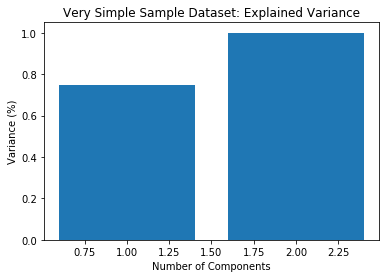

In [24]:
plotPCA(verySimple_pcaResult, "Very Simple Sample Dataset")

In [25]:
verySimple_featureValues_std_pca = transformDataViaPCA(verySimple_featureValues_std, verySimple_numberOfPCAComponents)

#### Test-Verfahren: Iris

In [26]:
pcaIrisTestResult, numberOfIrisTestPCAComponents  = getPCAComponents(sampleIrisFeatureValues_std, 0.9)

Die 2 ersten PCA Komponenten erklären mehr als 90.0 % der Varianz.


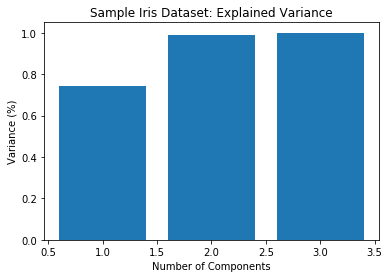

In [27]:
plotPCA(pcaIrisTestResult, "Sample Iris Dataset")

In [28]:
sampleIrisFeatureValues_std_pca = transformDataViaPCA(sampleIrisFeatureValues_std, numberOfIrisTestPCAComponents)

#### Test-Verfahren: Digits

In [29]:
pcaTestResult, numberOfTestPCAComponents  = getPCAComponents(sampleFeatureValues_std, 0.9)

Die 31 ersten PCA Komponenten erklären mehr als 90.0 % der Varianz.


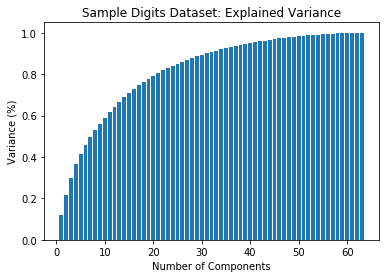

In [30]:
plotPCA(pcaTestResult, "Sample Digits Dataset")

In [31]:
sampleFeatureValues_std_pca = transformDataViaPCA(sampleFeatureValues_std, numberOfTestPCAComponents)

#### Verfahren

In [58]:
minExplainedVariance = 0.9
pcaResult, numberOfPCAComponents  = getPCAComponents(featureValues_std, minExplainedVariance)
print("Die" ,numberOfPCAComponents,"ersten PCA Komponenten erklären mehr als", minExplainedVariance * 100,"% der Varianz.")

Die 4 ersten PCA Komponenten erklären mehr als 90.0 % der Varianz.


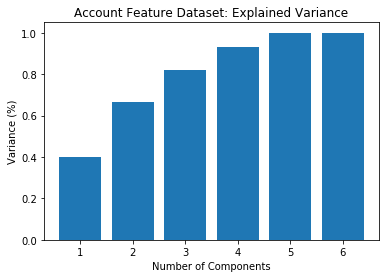

In [60]:
plotPCA(pcaResult, "Account Feature Dataset")

In [34]:
featureValues_std_pca = transformDataViaPCA(featureValues_std, numberOfPCAComponents)

# Die Anzahl der Cluster bestimmen

**Frage:** Soll ich hier schon die nach PCA transformierten feature values verwenden? Im Folgenden treffe ich die Annahme, dass die nach PCA transformierten feature values verwendet werden sollten.

#### Funktionen

In [35]:
def estimateNumberOfClusters(featureValues, featureValues_std_pca, maxNumberOfClusters):
    scores = []
    numberOfCluster = []

    for i in range(2,maxNumberOfClusters,1):
        kmeans_tmp = KMeans(n_clusters=i)
        kmeans_tmp.fit(featureValues_std_pca)
        numberOfCluster.append(i)
        scores.append(metrics.calinski_harabasz_score(featureValues, kmeans_tmp.labels_))  
    
    result = pd.DataFrame(np.transpose(np.array([numberOfCluster, scores])).astype(int), columns=["Number of Clusters", "C.H. Score"]);
    optimalNumberOfClusters = numberOfCluster[np.argmax(scores)];
    
    return result, optimalNumberOfClusters;

In [36]:
def plotScores(scores):
    plt.figure()
    plt.bar(scores.iloc[:, 0],scores.iloc[:, 1] )
    plt.xlabel('Number of Clusters')
    plt.ylabel('C.H. Score') #for each component
    plt.title('Calinski Harabasz Score')
    plt.show()

#### Test-Verfahren: Very Simple Dataset

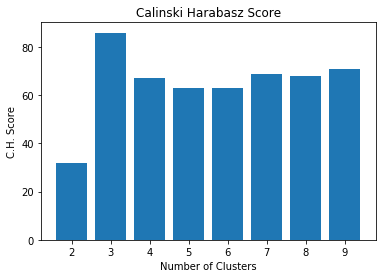

In [37]:
verySimple_scores, verySimple_optimalNumberOfClusters = estimateNumberOfClusters(verySimple_featureValues, verySimple_featureValues_std_pca, 10)
plotScores(verySimple_scores)

#### Test-Verfahren: Iris

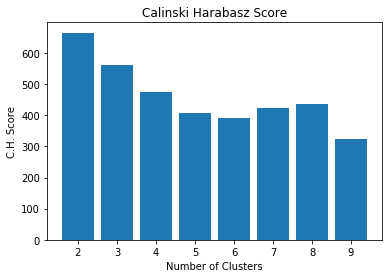

In [38]:
test_iris_scores, test_iris_optimalNumberOfClusters = estimateNumberOfClusters(sampleIrisFeatureValues, sampleIrisFeatureValues_std_pca, 10)
plotScores(test_iris_scores)

Anmerkung: Eigt sollte der C.H. Score bei den Nummer für 3 am höchsten sein.

#### Test-Verfahren: Digits

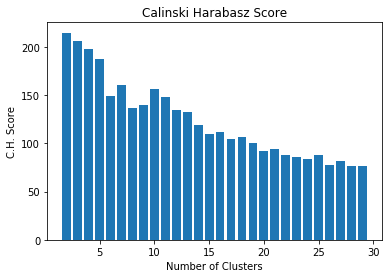

In [39]:
test_scores, test_optimalNumberOfClusters = estimateNumberOfClusters(sampleFeatureValues, sampleFeatureValues_std_pca, 30)
plotScores(test_scores)

Anmerkung: Eigt sollte der C.H. Score bei den Nummer für 10 am höchsten sein.

#### Verfahren

In [69]:
scores, optimalNumberOfClusters = estimateNumberOfClusters(featureValues, featureValues_std_pca, 10)
print("The optimal number of clusters is", optimalNumberOfClusters)

The optimal number of clusters is 6


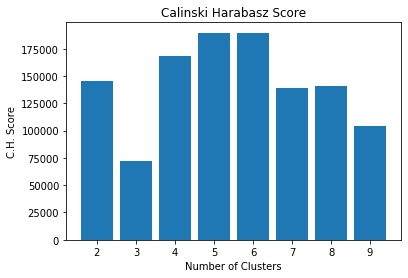

In [70]:
plotScores(scores)

# Ausreißer eliminieren

In [42]:
def remove_outliers(featureValues, featureValues_std_pca, kmeans, threshold):

    new_labels = [];
    new_featureValues = [];
    new_featureValues_std_pca = [];
    within_cluster_featureValues_std_pca = [];
    within_cluster_featureValues = [];
    new_labels = [];
    res1 = [];
    res2 = [];
    res3 = [];
    
    for i, center in enumerate(kmeans.cluster_centers_):

        within_cluster_featureValues_std_pca = featureValues_std_pca[kmeans.labels_==i]
        within_cluster_featureValues = featureValues[kmeans.labels_==i]
        
        centroid = kmeans.cluster_centers_[i]

        stdev = np.std(within_cluster_featureValues_std_pca, axis=0)
       
        keep = np.linalg.norm((centroid - within_cluster_featureValues_std_pca), axis=1) < threshold*np.linalg.norm(stdev)

        if (all(False == e for e in keep)):
            continue;
            
        new_featureValues_std_pca.append(within_cluster_featureValues_std_pca[keep])
        new_featureValues.append(within_cluster_featureValues[keep])
        
        new_labels.extend([i for j in range(len(within_cluster_featureValues_std_pca[keep]))])
        
    if (len(new_featureValues) > 1):
        res1 = np.vstack(new_featureValues)
        
    if (len(new_featureValues_std_pca) >1 ):
        res2 = np.vstack(new_featureValues_std_pca)
        
    if (len(new_labels) > 1):
        res3 = np.array(new_labels)
        
    return res1, res2, res3


#### Test-Verfahren: Very Simple Dataset

In [43]:
kmeans_opt = KMeans(n_clusters=verySimple_optimalNumberOfClusters)
kmeans_opt.fit(verySimple_featureValues_std_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [44]:
keep = [False, False, False, False, False, False, False]
all(False == e for e in keep)

for i in range(0,5,1):
    if (i == 0):
        continue; 
    else:
        print(i)

1
2
3
4


In [45]:
from sklearn.metrics import calinski_harabaz_score as ch_score

thresholds = np.linspace(.4,3, 20)

test = [remove_outliers(verySimple_featureValues, verySimple_featureValues_std_pca, kmeans_opt,t) for t in thresholds]

scores= []

for (res1, res2, labels) in test:
    if (len(res1)<=1 | len(res2)<=1 | len(labels) <= 1):
        continue;
    scores.append(metrics.calinski_harabasz_score(res2, labels)) 

In [46]:
print(len(scores))
print(len(labels))

20
17


Text(0.5, 1.0, 'Calinski Harabaz Scores as std threshold changes')

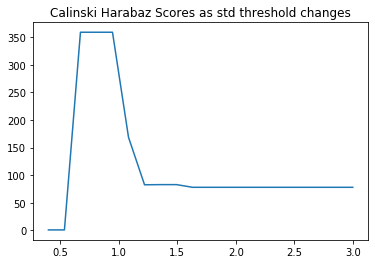

In [47]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

#### Verfahren

In [48]:
kmeans_opt = KMeans(n_clusters=optimalNumberOfClusters)
kmeans_opt.fit(featureValues_std_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [49]:
from sklearn.metrics import calinski_harabaz_score as ch_score

thresholds = np.linspace(.01,3, 20)

test = [remove_outliers(featureValues, featureValues_std_pca, kmeans_opt,t) for t in thresholds]

scores= []

for (res1, res2, labels) in test:
    scores.append(metrics.calinski_harabasz_score(res2, labels)) 

Text(0.5, 1.0, 'Calinski Harabaz Scores as std threshold changes')

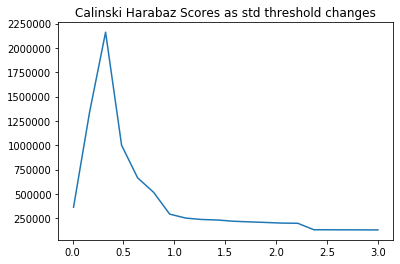

In [50]:
plt.plot(thresholds, scores)
plt.title('Calinski Harabaz Scores as std threshold changes')

In [51]:
optimalThreshold = thresholds[np.argmax(scores)]
print("The threshoppld leading to the highest Calinski Harabaz Score is", optimalThreshold)

The threshoppld leading to the highest Calinski Harabaz Score is 0.3247368421052632


# Berechnung und Visualisierung des Entscheidungsmodells via kmeans Cluster Analyse Verfahren 

In [52]:
featureValues_out, featureValues_std_pca_out, labels = remove_outliers(featureValues, featureValues_std_pca, kmeans_opt, optimalThreshold)
featureValues_std_pca_out = pd.DataFrame(featureValues_std_pca_out)
featureValues_out = pd.DataFrame(featureValues_out)

In [53]:
kmeans_opt.fit(featureValues_std_pca_out)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

#### Visualisierung

In [ ]:
from sklearn.manifold import TSNE

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
featureValues_std_pca_out_tsne = tsne.fit_transform(featureValues_std_pca_out)
featureValues_std_pca_out_tsne = pd.DataFrame(featureValues_std_pca_out_tsne, columns=["1_tsne_comp","1_tsne_comp"])
featureValues_std_pca_out_tsne.head()

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 125479 samples in 0.152s...
[t-SNE] Computed neighbors for 125479 samples in 3.477s...
[t-SNE] Computed conditional probabilities for sample 1000 / 125479
[t-SNE] Computed conditional probabilities for sample 2000 / 125479
[t-SNE] Computed conditional probabilities for sample 3000 / 125479
[t-SNE] Computed conditional probabilities for sample 4000 / 125479
[t-SNE] Computed conditional probabilities for sample 5000 / 125479
[t-SNE] Computed conditional probabilities for sample 6000 / 125479
[t-SNE] Computed conditional probabilities for sample 7000 / 125479
[t-SNE] Computed conditional probabilities for sample 8000 / 125479
[t-SNE] Computed conditional probabilities for sample 9000 / 125479
[t-SNE] Computed conditional probabilities for sample 10000 / 125479
[t-SNE] Computed conditional probabilities for sample 11000 / 125479
[t-SNE] Computed conditional probabilities for sample 12000 / 125479
[t-SNE] Computed conditional probab

[t-SNE] Computed conditional probabilities for sample 122000 / 125479
[t-SNE] Computed conditional probabilities for sample 123000 / 125479
[t-SNE] Computed conditional probabilities for sample 124000 / 125479
[t-SNE] Computed conditional probabilities for sample 125000 / 125479
[t-SNE] Computed conditional probabilities for sample 125479 / 125479
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.639572


In [ ]:
# Plot Digits t-SNE
import seaborn as sns

# Set style of scatterplot
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

featureValues_std_pca_out_tsne["Label"] = kmeans_opt.labels_
featureValues_std_pca_out_tsne.columns = ["x", "y", "Label"]

sns.lmplot(x='x',
           y='y',
           data=featureValues_std_pca_out_tsne,
           fit_reg=False,
           legend=True,
           height=9,
           hue='Label',
           scatter_kws={"s":200, "alpha":0.3})


plt.title('t-SNE Results:', weight='bold').set_fontsize('14')
plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')

## PCA 3d Diagramm

[]

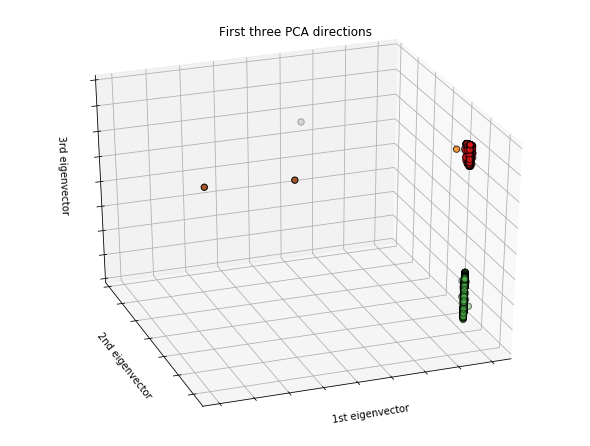

In [54]:
from mpl_toolkits.mplot3d import Axes3D
# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(featureValues_out)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=kmeans_opt.labels_,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

#### Radar Plots

# Verifiziere das Funktionieren des Entscheidungsmodells mit bekannten Adressen

# Identifiziere die von den Clustern repräsentierten Nutzergruppen

# Visualisiere die Interaktion zwischen den Clustern und interpretiere die Ergebnisse

# Temporary stuff

In [430]:
clusterMeans = []
for i, center in enumerate(kmeans_opt.cluster_centers_):
    within_cluster_featureValues = featureValues_out[kmeans_opt.labels_==i]
    within_cluster_featureValues.columns = ['weiReceived', 'weiSent', 'numberOfTranscationsReceived', 'numberOfTranscationsSent', 'avgTimeDiffBetweenSentTransactions', 'avgTimeDiffBetweenReceivedTransactions']
    clusterMeans.append(within_cluster_featureValues.mean())
clusterMeans

[weiReceived                               6.933649e+18
 weiSent                                   7.570623e+18
 numberOfTranscationsReceived              2.854468e+00
 numberOfTranscationsSent                  2.644681e+00
 avgTimeDiffBetweenSentTransactions        1.933578e+05
 avgTimeDiffBetweenReceivedTransactions    1.915551e+05
 dtype: float64, weiReceived                               5.323625e+18
 weiSent                                   5.248085e+18
 numberOfTranscationsReceived              1.140950e+00
 numberOfTranscationsSent                  1.127341e+00
 avgTimeDiffBetweenSentTransactions        9.741412e+01
 avgTimeDiffBetweenReceivedTransactions    1.196589e+02
 dtype: float64, weiReceived                               1.918363e+19
 weiSent                                   1.819940e+19
 numberOfTranscationsReceived              4.398769e+00
 numberOfTranscationsSent                  4.790907e+00
 avgTimeDiffBetweenSentTransactions        9.796833e+03
 avgTimeDiffBetw

In [460]:
 within_cluster_featureValues = featureValues_out[kmeans_opt.labels_==2]
within_cluster_featureValues.columns = ['weiReceived', 'weiSent', 'numberOfTranscationsReceived', 'numberOfTranscationsSent', 'avgTimeDiffBetweenSentTransactions', 'avgTimeDiffBetweenReceivedTransactions']
within_cluster_featureValues

,weiReceived,weiSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions
0,0,5000000000000000000,47,1,0,10909.8
1,2194529286109153479,2194529280000000000,86,43,13962.7,6902.96
4,94010000000000000000,175000000000000000000,12,5,18229.5,6793.18
9,183950000000000000000,183950000000000000000,43,43,14115.5,14115.5
11,2267000000000000000,1729477609512207807,18,77,2327.33,10404.5
...,...,...,...,...,...,...
121143,114910000000000000000,114858110000000000000,7,7,11538.2,11552.7
121147,11897586000000000000,11886102700000000000,7,4,17764.3,9241.67
121150,21409200000000000000,21031690000000000000,7,2,1137,10058
121153,15340000000000000000,8879424000000000000,7,1,0,12094


weiReceived                               6.933649e+18
weiSent                                   7.570623e+18
numberOfTranscationsReceived              2.854468e+00
numberOfTranscationsSent                  2.644681e+00
avgTimeDiffBetweenSentTransactions        1.933578e+05
avgTimeDiffBetweenReceivedTransactions    1.915551e+05
dtype: float64

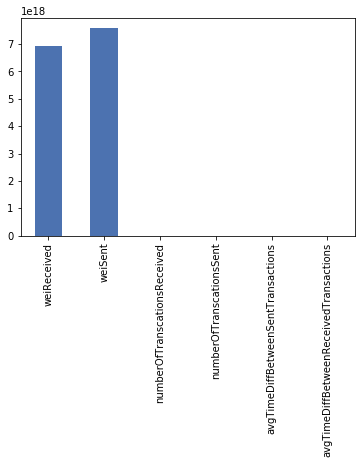

In [456]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

display(clusterMeans[0])
x = np.array(clusterMeans[0])
clusterMeans[0].plot.bar()

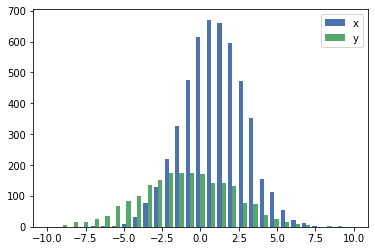

In [439]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

x = np.random.normal(1, 2, 5000)
y = np.random.normal(-1, 3, 2000)

bins = np.linspace(-10, 10, 30)

plt.hist([x, y], bins, label=['x', 'y'])
plt.legend(loc='upper right')
plt.show()

In [ ]:
featureValues_out[]

In [79]:
x = np.linspace(-10, 10, 30)
y = np.linspace(-10, 10, 30)
x[y<=5]

array([-10.        ,  -9.31034483,  -8.62068966,  -7.93103448,
        -7.24137931,  -6.55172414,  -5.86206897,  -5.17241379,
        -4.48275862,  -3.79310345,  -3.10344828,  -2.4137931 ,
        -1.72413793,  -1.03448276,  -0.34482759,   0.34482759,
         1.03448276,   1.72413793,   2.4137931 ,   3.10344828,
         3.79310345,   4.48275862])

In [85]:
array = np.array([[ 0,  1,  2,  3],
       [10, 11, 12, 13],
       [20, 21, 22, 23],
       [30, 31, 32, 33],
       [40, 41, 42, 43]])
array[-2,0:2]

array([30, 31])

In [145]:
array[0:2,:]

array([[ 0,  1,  2,  3],
       [10, 11, 12, 13]])

In [132]:
df = pd.DataFrame(array)
df

,0,1,2,3
0,0,1,2,3
1,10,11,12,13
2,20,21,22,23
3,30,31,32,33
4,40,41,42,43


In [142]:
df.loc[0:1,:]

,0,1,2,3
0,0,1,2,3
1,10,11,12,13


In [146]:
import numpy as np
mylist = list('abcedfghijklmnopqrstuvwxyz')
myarr = np.arange(26)
mydict = dict(zip(mylist, myarr))

In [159]:
zip(mylist, myarr).__next__()
zip(mylist, myarr).__next__()

('a', 0)

In [162]:
import numpy as np
ser1 = pd.Series(list('abcedfghijklmnopqrstuvwxyz'))
display(ser1)

0     a
1     b
2     c
3     e
4     d
5     f
6     g
7     h
8     i
9     j
10    k
11    l
12    m
13    n
14    o
15    p
16    q
17    r
18    s
19    t
20    u
21    v
22    w
23    x
24    y
25    z
dtype: object

In [161]:
ser2 = pd.Series(np.arange(26))
display(ser2)

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
dtype: int64

In [165]:
pd.DataFrame({"col1": ser1, "col2":ser2})

,col1,col2
0,a,0
1,b,1
2,c,2
3,e,3
4,d,4
5,f,5
6,g,6
7,h,7
8,i,8
9,j,9
